# BTC - EUR analysis

This notebook investigates the use of two tools, dash and fbprophet. Dash provides an intuitive way to create a web app that grants a user interactive access to graphs and charts. Fbprophet is a simple-to-use tool that lets you quickly find trends in time series data and make predictions.

Fbprophet uses as additive model. 

    y(t) = growth(t) + seasonality(t) + error

I have used historical data on bitcoin. 

In [23]:
import pandas as pd
from matplotlib import pyplot as plt
from fbprophet import Prophet

## Import data

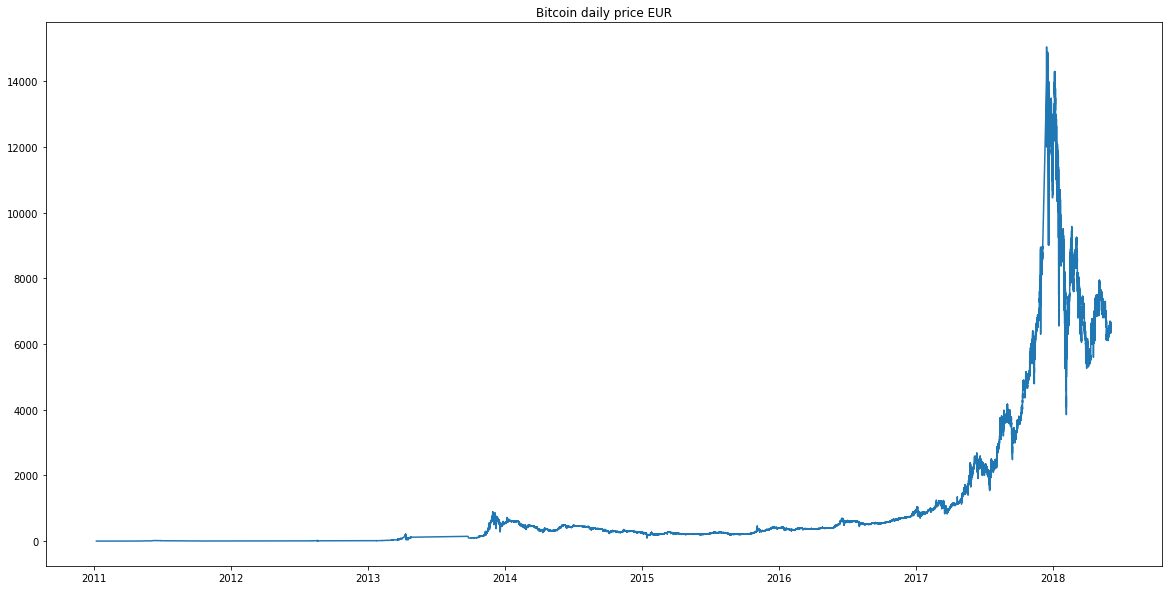

In [13]:
# Download desired csv from 'http://api.bitcoincharts.com/v1/csv/'

# Columns names are time, price, volume. Rename p/v to y to predict.

path='http://api.bitcoincharts.com/v1/csv/bcEUR.csv.gz'
df = pd.read_csv('bceur.csv', names=['t','p','v'])
df['ds']=pd.to_datetime(df['t'],unit='s')
# Set the date/time to be the index for the dataframe
df=df.drop(df.index[0:2])
#df=df.drop(df.index[-2:])
df.set_index('ds', inplace=True)

#Specify range!

df=df[:]

#ax = df['y'][:].plot(title="Bitcoin daily price EUR")
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.figure(figsize=(20,10)) 
plt.plot(df['p'],df['v'])
plt.title('Bitcoin daily price EUR')
plt.show()

## Dash web app
A basic web app that allows the user to simultaneously change the time range of both price and volume.

In [ ]:
import datetime
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

def fracDate(year):
    return str(int(year))+'-'+str(int((year-int(year))*12)+1)

app=dash.Dash()

app.layout = html.Div(children=[
    html.H1(children='BTC/EUR'),

    html.Div(id='time-range'),

    dcc.RangeSlider(
        id='year-slider',
        min=min(df.index).year+(min(df.index).month+1)/12,
        max=max(df.index).year+(max(df.index).month+1)/12,
        step=0.08,
        value = [2015,2016.5]
    ),

    html.Div(id='output-graph1'),
    html.Div(id='output-graph2')
])

@app.callback(
    Output(component_id='time-range', component_property='children'),
    [Input(component_id='year-slider', component_property='value')]
)
def update_time(input_data):

    return     html.Div(id='timerange',children='Timerange:\t'+str(fracDate(input_data[0]))+' - '+ str(fracDate(input_data[1])))

@app.callback(
    Output(component_id='output-graph1', component_property='children'),
    [Input(component_id='year-slider', component_property='value')]
)
def update_g1(input_data):

    return     dcc.Graph(
        id='graph1',
        figure={
            'data': [
                {'x':df[fracDate(input_data[0]):fracDate(input_data[1])].index, 'y': df[fracDate(input_data[0]):fracDate(input_data[1])].p, 'type': 'line', 'name': 'volume' },
            ],
            'layout': {
                'title':'Price'
            }
            
        })

@app.callback(
    Output(component_id='output-graph2', component_property='children'),
    [Input(component_id='year-slider', component_property='value')]
)
def update_g2(input_data):


    return     dcc.Graph(
        id='graph2',
        figure={
            'data': [
                {'x':df[fracDate(input_data[0]):fracDate(input_data[1])].index, 'y': df[fracDate(input_data[0]):fracDate(input_data[1])].v, 'type': 'line', 'name': 'volume' },
            ],
            'layout': {
                'title':'Volume'
            }
            
        })

if __name__ == '__main__':
    app.run_server(debug=False, port = 8057)

INFO:werkzeug: * Running on http://127.0.0.1:8057/ (Press CTRL+C to quit)


## Price time series analysis

In [29]:
dftemp=df['2015':].copy()
dftemp.reset_index(level=0, inplace=True)
dftemp['y']=dftemp['p']
forecast_data = dftemp[['ds', 'y']].copy()
del dftemp

In [37]:
forecast_data.sample(5)

,ds,y
94622,2017-04-26 15:38:36,1194.99
82827,2017-02-21 18:00:16,1057.00
185249,2018-03-08 08:31:50,8080.00
140966,2017-09-13 12:15:45,3170.10
34718,2015-10-25 15:11:23,249.00


In [31]:
m = Prophet(interval_width=0.90)
m.fit(forecast_data)

/Users/Adil/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


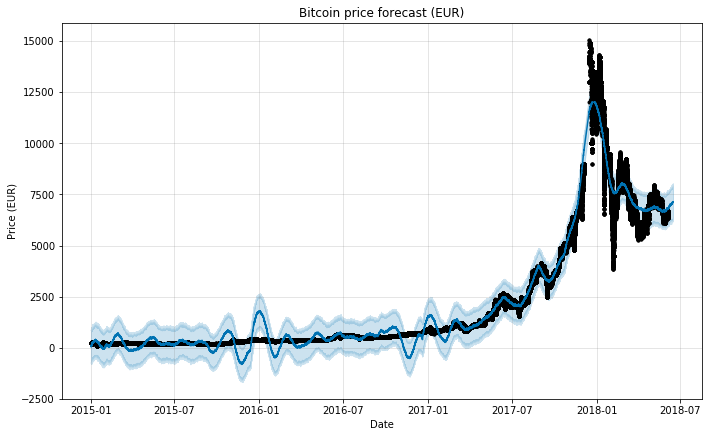

In [32]:
future = m.make_future_dataframe(periods=240, freq='H')

forecast = m.predict(future)
fig = m.plot(forecast, xlabel='Date', ylabel='Price (EUR)');
plt.title('Bitcoin price forecast (EUR)')
plt.show()

Trends in BTC price


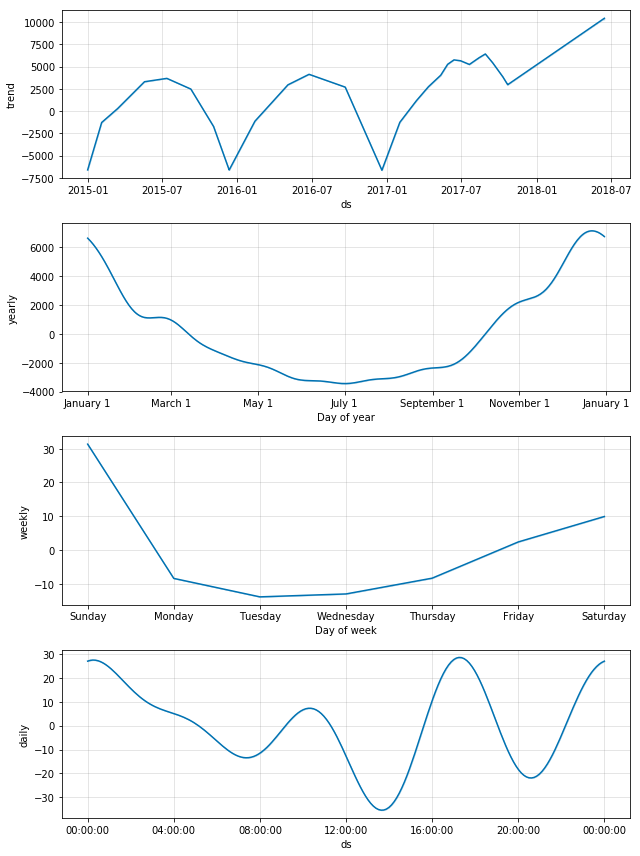

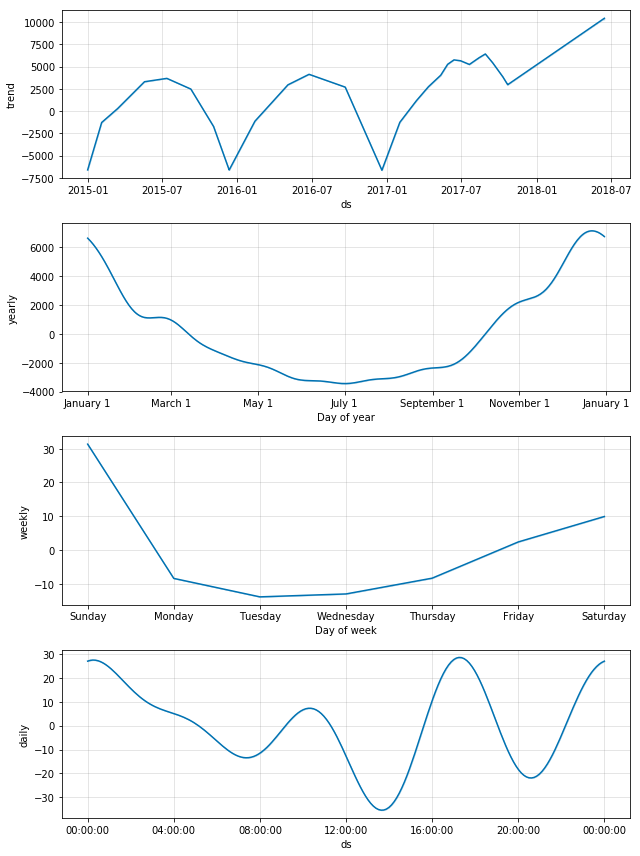

In [33]:
print('Trends in BTC price')
m.plot_components(forecast)

## Volume time series analysis

In [34]:
dftemp=df['2015':].copy()
dftemp.reset_index(level=0, inplace=True)
dftemp['y']=dftemp['v']
forecast_data_v = dftemp[['ds', 'y']].copy()
del dftemp

In [36]:
forecast_data_v.sample(5)

,ds,y
129945,2017-08-12 19:57:56,0.005670
62673,2016-07-07 05:01:14,0.040237
116231,2017-06-27 12:06:20,0.200000
147018,2017-10-07 00:08:56,0.000267
141056,2017-09-13 13:56:24,0.020782


In [41]:
m_v = Prophet(interval_width=0.90)
m_v.fit(forecast_data_v)

/Users/Adil/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


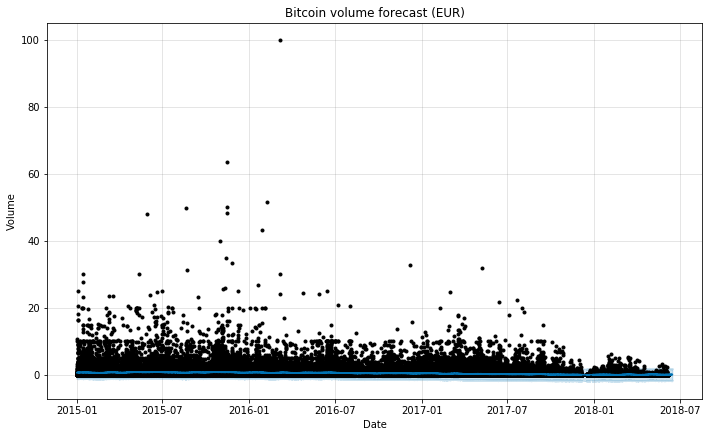

In [44]:
future_v = m_v.make_future_dataframe(periods=240, freq='H')

forecast_v = m_v.predict(future)
fig = m_v.plot(forecast_v, xlabel='Date', ylabel='Volume');
plt.title('Bitcoin volume forecast (EUR)')
plt.show()

Trends in BTC volume


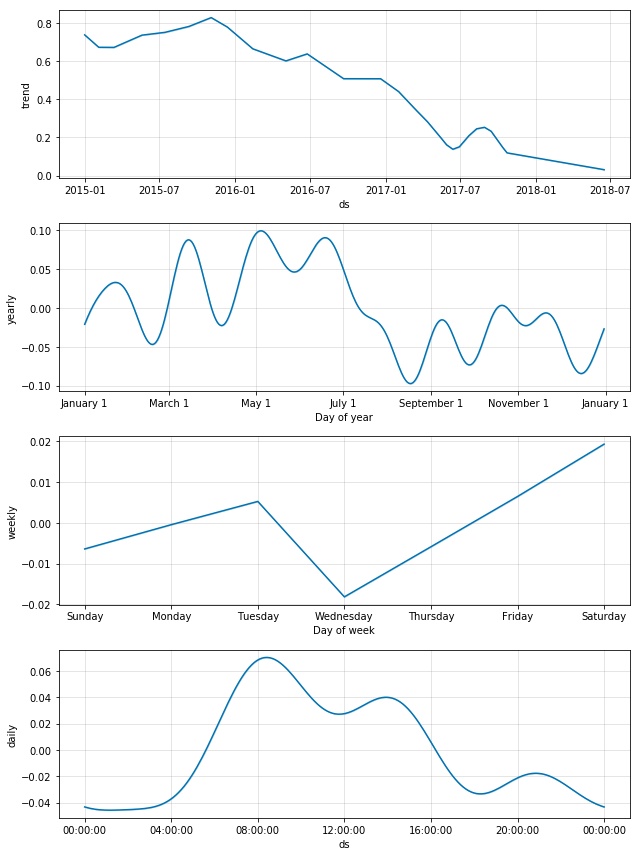

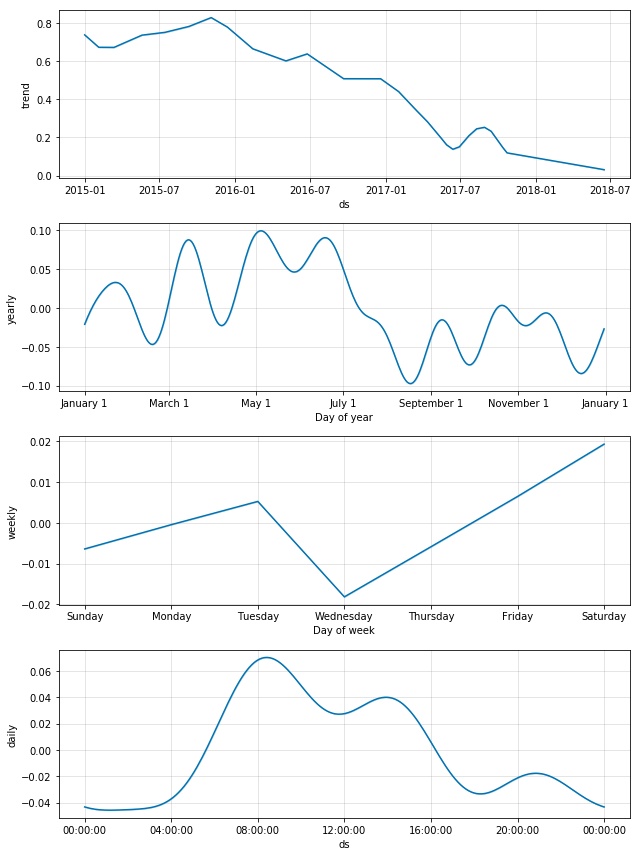

In [46]:
print('Trends in BTC volume')
m_v.plot_components(forecast_v)